**2.Phase 2 – (10 points)**

**2.1.Use SQL and Python to complete task 1.1 and recommend an employee for promotion (2 points)**

In [1]:
# Importing the required packages
import sqlite3
from sqlite3 import Error
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Non-functional approach to connecting
path = 'chinook.db'
connection = sqlite3.connect("chinook.db")

# Verify the connection
print("Database connected successfully.")

Database connected successfully.


In [7]:
# Function to create a connection to the database
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to the database was successful!")
    except Error as e:
        print(f"The error '{e}' occurred.")
    return connection

In [11]:
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The Error '{e}' occurred.")

**Total Sales By Employee**

In [14]:
#Calculating total sales by employee (sales representative)
q1 = '''

SELECT
    e.EmployeeId,
    e.FirstName || ' ' || e.LastName AS EmployeeName,
    SUM(i.Total) AS TotalSales
FROM
    invoices i
JOIN
    customers c ON i.CustomerId = c.CustomerId
JOIN
    employees e ON c.SupportRepId = e.EmployeeId
GROUP BY
    e.EmployeeId, e.FirstName, e.LastName
ORDER BY
    TotalSales DESC;

'''
out1 = execute_read_query(connection, q1)

# Converting the output to a DataFrame
columns = ["EmployeeId", "EmployeeName", "TotalSales"]
df1 = pd.DataFrame(out1, columns=columns)

# Displaying the DataFrame
df1

,EmployeeId,EmployeeName,TotalSales
0,3,Jane Peacock,833.04
1,4,Margaret Park,775.40
2,5,Steve Johnson,720.16


**Number Of Customers Handled By Each Employee**

In [16]:
# Number of customers handled by each employee

q2 = '''

SELECT
    e.EmployeeId,
    e.FirstName || ' ' || e.LastName AS EmployeeName,
    COUNT(c.CustomerId) AS CustomerCount
FROM
    customers c
JOIN
    employees e ON c.SupportRepId = e.EmployeeId
GROUP BY
    e.EmployeeId, e.FirstName, e.LastName
ORDER BY
    CustomerCount DESC;

  '''

out2 = execute_read_query(connection, q2)

# Converting the output to a DataFrame
columns = ["EmployeeId", "EmployeeName", "CustomerCount"]
df2 = pd.DataFrame(out2, columns=columns)

# Displaying the DataFrame
df2

,EmployeeId,EmployeeName,CustomerCount
0,3,Jane Peacock,21
1,4,Margaret Park,20
2,5,Steve Johnson,18


**Customer Relations Score**

In [18]:
#Customer Relations Score for Each Employee:

q3 = '''

WITH TotalSalesByEmployee AS (
    SELECT
        c.SupportRepId AS EmployeeId,
        SUM(i.Total) AS TotalSales
    FROM
        invoices i
    JOIN
        customers c ON i.CustomerId = c.CustomerId
    GROUP BY
        c.SupportRepId
),
CustomerCountByEmployee AS (
    SELECT
        c.SupportRepId AS EmployeeId,
        COUNT(c.CustomerId) AS CustomerCount
    FROM
        customers c
    GROUP BY
        c.SupportRepId
),
CustomerRelations AS (
    SELECT
        ts.EmployeeId,
        ts.TotalSales,
        cc.CustomerCount,
        cc.CustomerCount + (ts.TotalSales / cc.CustomerCount) AS CustomerRelationsScore
    FROM
        TotalSalesByEmployee ts
    JOIN
        CustomerCountByEmployee cc ON ts.EmployeeId = cc.EmployeeId
)
SELECT
    e.EmployeeId,
    e.FirstName || ' ' || e.LastName AS EmployeeName,
    cr.TotalSales,
    cr.CustomerCount,
    cr.CustomerRelationsScore
FROM
    CustomerRelations cr
JOIN
    employees e ON cr.EmployeeId = e.EmployeeId
ORDER BY
    cr.CustomerRelationsScore DESC;

'''

out3 = execute_read_query(connection, q3)

# Converting the output to a DataFrame
columns = ["EmployeeId", "EmployeeName", "TotalSales", "CustomerCount", "CustomerRelationsScore"]
df3 = pd.DataFrame(out3, columns=columns)

# Displaying the DataFrame
df3


,EmployeeId,EmployeeName,TotalSales,CustomerCount,CustomerRelationsScore
0,3,Jane Peacock,833.04,21,60.668571
1,4,Margaret Park,775.40,20,58.770000
2,5,Steve Johnson,720.16,18,58.008889


**Employee Tenure**

In [20]:
# Calculate Tenure of employees

q4 = '''
SELECT
    EmployeeId,
    FirstName || ' ' || LastName AS EmployeeName,
    HireDate,
    CAST((JULIANDAY('now') - JULIANDAY(HireDate)) / 365 AS INTEGER) AS Tenure
FROM
    employees
WHERE
    EmployeeId IN (3, 4, 5);
    '''

out4 = execute_read_query(connection, q4)

# Converting the output to a DataFrame
columns = ["EmployeeId", "EmployeeName", "HireDate", "Tenure"]
df4 = pd.DataFrame(out4, columns=columns)

# Displaying the DataFrame
df4


,EmployeeId,EmployeeName,HireDate,Tenure
0,3,Jane Peacock,2002-04-01 00:00:00,22
1,4,Margaret Park,2003-05-03 00:00:00,21
2,5,Steve Johnson,2003-10-17 00:00:00,21


**Calculating Weighted Score For Selected Metric**

In [38]:
# Weighted Score:

q5 = '''
WITH TotalSales AS (
    SELECT c.SupportRepId AS EmployeeId, SUM(i.Total) AS TotalSales
    FROM Invoices i
    JOIN Customers c ON i.CustomerId = c.CustomerId
    GROUP BY c.SupportRepId
),
CustomersHandled AS (
    SELECT SupportRepId AS EmployeeId, COUNT(CustomerId) AS CustomerCount
    FROM Customers
    GROUP BY SupportRepId
),
CustomerRelations AS (
    SELECT t.EmployeeId, t.TotalSales, ch.CustomerCount,
           (ch.CustomerCount + (t.TotalSales * 1.0 / ch.CustomerCount)) AS CustomerRelationsScore
    FROM TotalSales t
    JOIN CustomersHandled ch ON t.EmployeeId = ch.EmployeeId
),
EmployeeTenure AS (
    SELECT EmployeeId, (JULIANDAY('now') - JULIANDAY(HireDate)) / 365 AS Tenure
    FROM Employees
),
PromotionMetrics AS (
    SELECT cr.EmployeeId, cr.TotalSales, cr.CustomerRelationsScore, et.Tenure
    FROM CustomerRelations cr
    JOIN EmployeeTenure et ON cr.EmployeeId = et.EmployeeId
),
MaxValues AS (
    SELECT MAX(TotalSales) AS MaxTotalSales, MAX(CustomerRelationsScore) AS MaxCustomerRelationsScore, MAX(Tenure) AS MaxTenure
    FROM PromotionMetrics
),
WeightedScores AS (
    SELECT pm.EmployeeId,
           pm.TotalSales,
           pm.CustomerRelationsScore,
           pm.Tenure,
           (0.6 * (pm.TotalSales * 1.0 / mv.MaxTotalSales) +
            0.2 * (pm.CustomerRelationsScore * 1.0 / mv.MaxCustomerRelationsScore) +
            0.2 * (pm.Tenure * 1.0 / mv.MaxTenure)) AS WeightedScore
    FROM PromotionMetrics pm, MaxValues mv
)
SELECT 
    ws.EmployeeId,
    e.FirstName,
    e.LastName,
    ws.TotalSales,
    ws.CustomerRelationsScore,
    ws.Tenure,
    ws.WeightedScore,
    RANK() OVER (ORDER BY ws.WeightedScore DESC) AS Rank
FROM WeightedScores ws
JOIN Employees e ON ws.EmployeeId = e.EmployeeId
ORDER BY Rank;
    '''

out5 = execute_read_query(connection, q5)

# Converting the output to a DataFrame
columns = ["EmployeeId", "FirstName", "LastName", "TotalSales", "CustomerRelationsScore", "Tenure", "WeightedScore", "Rank"]
df5 = pd.DataFrame(out5, columns=columns)

# Displaying the DataFrame
df5


,EmployeeId,FirstName,LastName,TotalSales,CustomerRelationsScore,Tenure,WeightedScore,Rank
0,3,Jane,Peacock,833.04,60.668571,22.678638,1.000000,1
1,4,Margaret,Park,775.40,58.770000,21.590967,0.942634,2
2,5,Steve,Johnson,720.16,58.008889,21.133433,0.896303,3


**Ranking employees based on the weighted score**

In [40]:
# Ranking employees based on the weighted score

q6 = '''

WITH TotalSales AS (
    SELECT
        c.SupportRepId AS EmployeeId,
        SUM(i.Total) AS TotalSales
    FROM
        invoices i
    JOIN
        customers c ON i.CustomerId = c.CustomerId
    GROUP BY
        c.SupportRepId
),
CustomerCount AS (
    SELECT
        SupportRepId AS EmployeeId,
        COUNT(CustomerId) AS CustomerCount
    FROM
        customers
    GROUP BY
        SupportRepId
),
CustomerRelations AS (
    SELECT
        ts.EmployeeId,
        ts.TotalSales,
        cc.CustomerCount,
        (cc.CustomerCount + (ts.TotalSales * 1.0 / cc.CustomerCount)) AS CustomerRelationsScore
    FROM
        TotalSales ts
    JOIN
        CustomerCount cc ON ts.EmployeeId = cc.EmployeeId
),
TenureData AS (
    SELECT
        e.EmployeeId,
        e.FirstName || ' ' || e.LastName AS EmployeeName,
        DATE('now') AS Today,
        e.HireDate,
        CAST((JULIANDAY('now') - JULIANDAY(e.HireDate)) / 365 AS INTEGER) AS Tenure
    FROM
        employees e
),
WeightedScores AS (
    SELECT
        cr.EmployeeId,
        td.EmployeeName,
        cr.TotalSales,
        cr.CustomerRelationsScore,
        td.Tenure,
        (0.6 * (cr.TotalSales * 1.0 / (SELECT MAX(TotalSales) FROM CustomerRelations)) +
         0.2 * (cr.CustomerRelationsScore * 1.0 / (SELECT MAX(CustomerRelationsScore) FROM CustomerRelations)) +
         0.2 * (td.Tenure * 1.0 / (SELECT MAX(Tenure) FROM TenureData))) AS WeightedScore
    FROM
        CustomerRelations cr
    JOIN
        TenureData td ON cr.EmployeeId = td.EmployeeId
),
RankedEmployees AS (
    SELECT
        *,
        RANK() OVER (ORDER BY WeightedScore DESC) AS Rank
    FROM
        WeightedScores
)
SELECT
    EmployeeId,
    EmployeeName,
    TotalSales,
    CustomerRelationsScore,
    Tenure,
    WeightedScore,
    Rank
FROM
    RankedEmployees
WHERE
    Rank = 1;
    '''

out6 = execute_read_query(connection, q6)

# Converting the output to a DataFrame
columns = ["EmployeeId", "EmployeeName", "TotalSales", "CustomerRelationsScore", "Tenure", "WeightedScore", "Rank"]
df6 = pd.DataFrame(out6, columns=columns)

# Displaying the DataFrame
df6

,EmployeeId,EmployeeName,TotalSales,CustomerRelationsScore,Tenure,WeightedScore,Rank
0,3,Jane Peacock,833.04,60.668571,22,1.0,1


**2.2. Use SQL and Python to complete task 1.2 and create the histogram (2 points)**

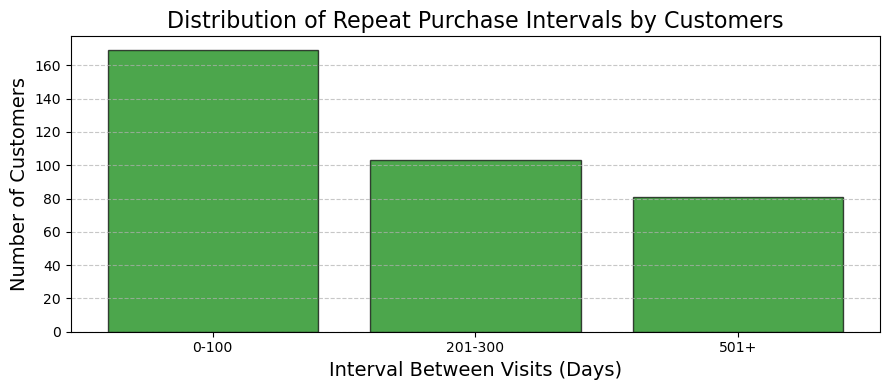

In [56]:
# Histogram of 'Distribution of Repeat Purchase Intervals by Customers'
q7 = """
WITH PurchaseIntervals AS (
    SELECT
        CustomerId,
        JULIANDAY(InvoiceDate) - JULIANDAY(PreviousVisitDate) AS IntervalDays
    FROM
        (SELECT
            CustomerId,
            InvoiceDate,
            LAG(InvoiceDate) OVER (PARTITION BY CustomerId ORDER BY InvoiceDate) AS PreviousVisitDate
         FROM
            invoices
        )
    WHERE
        PreviousVisitDate IS NOT NULL
)
SELECT
    CASE
        WHEN IntervalDays <= 100 THEN '0-100'
        WHEN IntervalDays <= 200 THEN '101-200'
        WHEN IntervalDays <= 300 THEN '201-300'
        WHEN IntervalDays <= 400 THEN '301-400'
        WHEN IntervalDays <= 500 THEN '401-500'
        ELSE '501+'
    END AS IntervalBin,
    COUNT(*) AS NumberOfCustomers
FROM
    PurchaseIntervals
GROUP BY
    IntervalBin
ORDER BY
    IntervalBin;
"""
data = execute_read_query(connection, q7)
columns = ["IntervalBin", "NumberOfCustomers"]
dfhist= pd.DataFrame(data, columns=columns)

# Plotting the histogram
plt.figure(figsize=(9, 4))
plt.bar(dfhist['IntervalBin'], dfhist['NumberOfCustomers'], color='green', edgecolor='black', alpha=0.7)

# Adding titles and labels
plt.title('Distribution of Repeat Purchase Intervals by Customers', fontsize=16)
plt.xlabel('Interval Between Visits (Days)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

# Adding gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


Inferences from the Histogram:

**Majority of Repeat Purchases (0-100 Days):**

The largest proportion of customers (over 160) make repeat purchases within 0-100 days of their previous visit.

This indicates a loyal customer base with frequent purchases within a short timeframe.

**Moderate Repeat Purchases (201-300 Days):**

The second largest group of customers (approximately 100) makes purchases after a moderate interval of 201-300 days.

These customers may exhibit less frequent but consistent purchasing behavior.

**Least Frequent Purchases (501+ Days):**

The smallest group of customers (around 80) makes purchases after an extended gap of 501+ days.
These customers might be occasional buyers or have a low level of brand loyalty.

**No Purchases in Intermediate Intervals (101-200, 301-500 Days):**

The histogram shows no data for intervals of 101-200 and 301-500 days.
This could indicate a potential data gap or that customers tend to cluster their purchase behaviors into specific time ranges (e.g., very frequent, moderately frequent, or infrequent).

**Actionable Insights:**

Retention Strategies:  

Need to focus on marketing efforts on the frequent buyers (0-100 days) to maintain their loyalty and encourage upselling.

Re-engagement Campaigns:

Target the less frequent customers (501+ days) with tailored promotions or reminders to bring them back sooner.
Moderate Buyers: Understand the behavior of customers in the 201-300 days range and offer incentives to encourage more frequent purchases.

**Business Opportunity:**

We need to Investigate why there are no purchases recorded for intervals like 101-200 or 301-500 days.Have to  Address any operational or marketing gaps that exists.

**2.3. Use SQL and Python to complete task 1.3 and show the initial value of the metric that you chose (2 points)**

**Average Purchase Value by Customer**

In [58]:
q8 = '''
WITH CustomerAveragePurchase AS (
    SELECT
        c.CustomerId,
        c.FirstName || ' ' || c.LastName AS CustomerName,
        AVG(i.Total) AS AveragePurchaseValue
    FROM
        customers c
    INNER JOIN
        invoices i ON c.CustomerId = i.CustomerId
    GROUP BY
        c.CustomerId, c.FirstName, c.LastName
)
SELECT
    CustomerId,
    CustomerName,
    AveragePurchaseValue
FROM
    CustomerAveragePurchase
ORDER BY
    AveragePurchaseValue DESC;
    '''

out8 = execute_read_query(connection, q8)

# Converting the output to a DataFrame
columns = ["CustomerId", "CustomerName", "AveragePurchaseValue"]
df8 = pd.DataFrame(out8, columns=columns)

# Displaying the DataFrame
df8.head()


,CustomerId,CustomerName,AveragePurchaseValue
0,6,Helena Holý,7.088571
1,26,Richard Cunningham,6.802857
2,57,Luis Rojas,6.660000
3,45,Ladislav Kovács,6.517143
4,46,Hugh O'Reilly,6.517143


**Genre Popularity Analysis**

In [ ]:
# Genre Popularity Analysis
q9 = '''
WITH GenreSales AS (
    SELECT
        g.Name AS Genre,
        SUM(ii.UnitPrice * ii.Quantity) AS TotalSales
    FROM
        invoice_items ii
    INNER JOIN
        tracks t ON ii.TrackId = t.TrackId
    INNER JOIN
        genres g ON t.GenreId = g.GenreId
    GROUP BY
        g.Name
)
SELECT
    Genre,
    TotalSales
FROM
    GenreSales
ORDER BY
    TotalSales DESC;
    '''

out9 = execute_read_query(connection, q9)

# Converting the output to a DataFrame
columns = ["Genre", "TotalSales"]
df9 = pd.DataFrame(out9, columns=columns)

# Displaying the DataFrame
df9.head()

,Genre,TotalSales
0,Rock,826.65
1,Latin,382.14
2,Metal,261.36
3,Alternative & Punk,241.56
4,TV Shows,93.53


**Artist Popularity**

In [60]:
#  Grouping by SupportRepId (employee) and calculating total sales
q10 = '''
WITH ArtistPopularity AS (SELECT a.ArtistId, a.Name AS ArtistName, 
COUNT(al.AlbumId) AS AlbumCount,       
SUM(ii.Quantity) AS TotalQuantitySold  
FROM artists AS a
LEFT JOIN albums AS al ON al.ArtistId = a.ArtistId
LEFT JOIN tracks AS t ON t.AlbumId = al.AlbumId
LEFT JOIN invoice_items AS ii ON ii.TrackId = t.TrackId
GROUP BY a.ArtistId)
SELECT * 
FROM ArtistPopularity
ORDER BY TotalQuantitySold DESC; 
'''
out10 = execute_read_query(connection, q10)

# Converting the output to a DataFrame
columns = ["ArtistId", "ArtistName", "AlbumCount", "TotalQuantitySold"]
df10 = pd.DataFrame(out10, columns=columns)

# Displaying the DataFrame
df10.head()

,ArtistId,ArtistName,AlbumCount,TotalQuantitySold
0,90,Iron Maiden,230,140.0
1,150,U2,151,107.0
2,50,Metallica,124,91.0
3,22,Led Zeppelin,124,87.0
4,113,Os Paralamas Do Sucesso,55,45.0


In [ ]:
**Sales per by Country**

In [68]:
#  Grouping by SupportRepId (employee) and calculating total sales
q11 = '''
SELECT c.Country, SUM(ii.Quantity * ii.UnitPrice) AS TotalSales
FROM Customers AS c
JOIN invoices AS i ON c.CustomerId = i.CustomerId
JOIN invoice_items AS ii ON i.InvoiceId = ii.InvoiceId
GROUP BY c.Country
ORDER BY TotalSales DESC
'''

# Executing the query and converting the output into a DataFrame
out11 = execute_read_query(connection, q11)

columns = ["Country", "TotalSales"]
df11 = pd.DataFrame(out11, columns=columns)

# Displaying the DataFrame
df11.head()


,Country,TotalSales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48


In [ ]:
## Pros of the metric: Gives the company an idea of revenue contribution by country to make important business decisions like allocation of resources,
## Opening additional stores/cutting down on them and management of inventory
## Cons of the metric: Using only sales to make these business decisions could be biased as there are several factors like socio-economic, trends,
## preferences by customers that can affect this metric 

**2.4 Some customers make multiple purchases. Therefore, each customer has different total purchasing amounts. We want to know the first name, last name, address, phone, email, total amount, and spending ranks of the customers who are 2nd, 3rd, 5th, 8th, and 12th highest in purchasing. Include your SQL queries and result screenshot. (4 points)**

In [ ]:
q11 = '''
WITH CustomerTotalPurchases AS (
    SELECT
        c.CustomerId,
        c.FirstName,
        c.LastName,
        c.Address,
        c.Phone,
        c.Email,
        SUM(i.Total) AS TotalAmount
    FROM
        customers c
    INNER JOIN
        invoices i ON c.CustomerId = i.CustomerId
    GROUP BY
        c.CustomerId, c.FirstName, c.LastName, c.Address, c.Phone, c.Email
),
RankedCustomers AS (
    SELECT
        CustomerId,
        FirstName,
        LastName,
        Address,
        Phone,
        Email,
        TotalAmount,
        DENSE_RANK() OVER (ORDER BY TotalAmount DESC) AS SpendingRank
    FROM
        CustomerTotalPurchases
)
SELECT
    CustomerId,
    FirstName,
    LastName,
    Address,
    Phone,
    Email,
    TotalAmount,
    SpendingRank
FROM
    RankedCustomers
WHERE
    SpendingRank IN (2, 3, 5, 8, 12)
ORDER BY
    SpendingRank;
'''

out11 = execute_read_query(connection, q11)

# Converting the output to a DataFrame
columns = ["CustomerId", "FirstName", "LastName", "Address", "Phone", "Email", "TotalAmount", "SpendingRank"]
df11 = pd.DataFrame(out11, columns=columns)

# Displaying the DataFrame
df11

,CustomerId,FirstName,LastName,Address,Phone,Email,TotalAmount,SpendingRank
0,26,Richard,Cunningham,2211 W Berry Street,+1 (817) 924-7272,ricunningham@hotmail.com,47.62,2
1,57,Luis,Rojas,"Calle Lira, 198",+56 (0)2 635 4444,luisrojas@yahoo.cl,46.62,3
2,28,Julia,Barnett,302 S 700 E,+1 (801) 531-7272,jubarnett@gmail.com,43.62,5
3,44,Terhi,Hämäläinen,Porthaninkatu 9,+358 09 870 2000,terhi.hamalainen@apple.fi,41.62,8
4,1,Luís,Gonçalves,"Av. Brigadeiro Faria Lima, 2170",+55 (12) 3923-5555,luisg@embraer.com.br,39.62,12
5,3,François,Tremblay,1498 rue Bélanger,+1 (514) 721-4711,ftremblay@gmail.com,39.62,12
6,4,Bjørn,Hansen,Ullevålsveien 14,+47 22 44 22 22,bjorn.hansen@yahoo.no,39.62,12
7,20,Dan,Miller,541 Del Medio Avenue,+1 (650) 644-3358,dmiller@comcast.com,39.62,12
8,22,Heather,Leacock,120 S Orange Ave,+1 (407) 999-7788,hleacock@gmail.com,39.62,12
9,42,Wyatt,Girard,"9, Place Louis Barthou",+33 05 56 96 96 96,wyatt.girard@yahoo.fr,39.62,12
